In [3]:
import pandas as pd
import datetime
import numpy as np
from tqdm import tqdm
import time
from itertools import combinations

#시각화
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
sns.set_style('whitegrid')
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectPercentile
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE , ADASYN
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn import metrics 
from sklearn.model_selection import StratifiedKFold , KFold

#모델링
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.base import ClassifierMixin
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.ensemble import ExtraTreesClassifier 
from catboost import CatBoostClassifier

- read data

In [4]:
pd.set_option('max_columns',100)

path = './data'

data = pd.read_csv(path + '/trainset.csv')
test = pd.read_csv( path + '/testset_final.csv')
sub = pd.read_csv( path + '/sample_submission_final.csv')

In [5]:
data['매니저생년월일'] = data['매니저생년월일'].apply(lambda x : x[:4])
data = data.drop(['매니저최초가입일' , '매니저최초서비스일' , '매니저주소'] , axis = 1 )

- 결측치 제거

In [6]:
#결측 제거
data[['반려동물','우선청소','매니저사용휴대폰','매니저이동방법']] = data[['반려동물','우선청소','매니저사용휴대폰','매니저이동방법']].fillna('정보없음')
data[['부재중여부','CS교육이수여부','청소교육이수여부']] = data[['부재중여부','CS교육이수여부','청소교육이수여부']].fillna(0)

test[['반려동물','우선청소','매니저사용휴대폰','매니저이동방법']] = test[['반려동물','우선청소','매니저사용휴대폰','매니저이동방법']].fillna('정보없음')
test[['부재중여부','CS교육이수여부','청소교육이수여부']] = test[['부재중여부','CS교육이수여부','청소교육이수여부']].fillna(0)

In [7]:
# test 결재형태 결측 제거 - train의 결재형태 최빈값으로 채워줌
test['결재형태'] = test['결재형태'].fillna('신용카드')

In [8]:
#평수 결측값 제거
new_feet = {
'10평대' : 0,
'20평대' : 1,
'30평대' : 2,
'40평대이상' : 3    
}

data['평수'] = data['평수'].map(new_feet).fillna(2)
test['평수'] = test['평수'].map(new_feet).fillna(2)

- Feature engineering

In [9]:
#일자 데이터 datetime으로 변경
time_cols = ['접수일','접수시각', '최초서비스일', '서비스일자', '서비스시작시간','서비스종료시간', '고객가입일']

data[time_cols] = data[time_cols].apply(pd.to_datetime)
test[time_cols] = test[time_cols].apply(pd.to_datetime)

In [10]:
#서비스요일 변경
data['서비스요일'] = data['서비스일자'].apply(lambda x: x.weekday())

test['서비스요일'] = test['서비스일자'].apply(lambda x: x.weekday())

In [11]:
#가입_최초서비스 : 최초서비스일 - 고객가입일

service_to_day = (data['서비스일자'] - data['최초서비스일']).mean()
na_index = test['고객가입일'].isna()
test.loc[na_index, '고객가입일'] = test[test['고객가입일'].isna()].apply(lambda x : x['최초서비스일'] - service_to_day, axis = 1)

In [12]:
# 고객가입일_time

data['고객가입_year'] = data['고객가입일'].dt.year
data['고객가입_month'] = data['고객가입일'].dt.month
data['고객가입_day'] = data['고객가입일'].dt.day
data['고객가입_요일'] = data['고객가입일'].dt.weekday

test['고객가입_year'] = test['고객가입일'].dt.year
test['고객가입_month'] = test['고객가입일'].dt.month
test['고객가입_day'] = test['고객가입일'].dt.day
test['고객가입_요일'] = test['고객가입일'].dt.weekday

In [13]:
# 서비스 주소 == 근무가능주소 
add_lst = list(data['서비스주소'].unique())

add_seoul = [i for i in add_lst if '서울' in i]
add_ch = [i for i in add_lst if '충남' in i]
add_gw = [i for i in add_lst if '강원' in i]
add_pt = [i for i in add_lst if '평택' in i]
add_gj = [i for i in add_lst if '광주' in i]
add_city = [i for i in add_lst if ('서울' in i) or ('경기' in i)]
add_bs = [i for i in add_lst if '부산' in i]

def add_modify(address):
    if address in add_seoul: return '서울'
    elif address in add_ch: return '천안/아산'
    elif address in add_gw: return '원주/춘천'
    elif address in add_pt: return '평택'
    elif address in add_gj: return '광주'
    elif address in add_city: return '수도권'
    elif address in add_bs: return '부산'
    else: return '기타'

def matching_add(service, possible):
    if service == possible:
        return 1
    elif (service == '서울') and (possible == '수도권'):
        return 1
    else :
        return 0

data['서비스주소_2'] = data['서비스주소'].apply(add_modify)
data['지역_매칭'] = data.apply(lambda x: matching_add(x.서비스주소_2,x.근무가능지역),axis=1)
data.drop('서비스주소_2',axis = 1,inplace = True)

test['서비스주소_2'] = test['서비스주소'].apply(add_modify)
test['지역_매칭'] = test.apply(lambda x: matching_add(x.서비스주소_2,x.근무가능지역),axis=1)
test.drop('서비스주소_2',axis = 1,inplace = True)

In [14]:
# 총서비스시간
data['서비스시작시간'] = data['서비스시작시간'].apply(lambda x: x.hour)
data['서비스종료시간'] = data['서비스종료시간'].apply(lambda x: x.hour)

data['총서비스시간'] = data['서비스종료시간'] - data['서비스시작시간']

test['서비스시작시간'] = test['서비스시작시간'].apply(lambda x: x.hour)
test['서비스종료시간'] = test['서비스종료시간'].apply(lambda x: x.hour)

test['총서비스시간'] = test['서비스종료시간'] - test['서비스시작시간']

In [15]:
#서비스 월
data['서비스월'] = data['서비스일자'].apply(lambda x: x.month)

test['서비스월'] = test['서비스일자'].apply(lambda x: x.month)

In [16]:
#서비스일자와 접수일자 차이
def 서비스_접수_차이(service_day, recep_day):
    time = service_day - recep_day
    return time.days

data['서비스-접수-차이'] = data.apply(lambda x: 서비스_접수_차이(x.서비스일자,x.접수일),axis=1)
test['서비스-접수-차이'] = test.apply(lambda x: 서비스_접수_차이(x.서비스일자,x.접수일),axis=1)

In [17]:
#매니저 연령대

def age(recep_day,birth):
    return recep_day.year - int(birth) + 1
       
data['매니저연령'] = data.apply(lambda x: age(x.접수일,x.매니저생년월일),axis=1)
data['매니저연령대'] = data['매니저연령'].apply(lambda x: int(str(x)[0]))
data['매니저연령_qcut'] = data['매니저연령'].apply(lambda x: 0 if x <= 50 else ( 1 if x <= 52 else ( 2 if x <= 56 else ( 3 if x <= 60 else 4))))

test['매니저연령'] = test.apply(lambda x: age(x.접수일,x.매니저생년월일),axis=1)
test['매니저연령대'] = test['매니저연령'].apply(lambda x: int(str(x)[0]))
test['매니저연령_qcut'] = test['매니저연령'].apply(lambda x: 0 if x <= 50 else ( 1 if x <= 52 else ( 2 if x <= 56 else ( 3 if x <= 60 else 4))))

In [18]:
#부재중 서비스가능여부와 부재중여부 일치
def 부재중(possible,whether):
    return '서비스가능여부' + str(possible) + '/부재중여부' + str(whether)

data['부재중_일치'] = data.apply(lambda x : 부재중(x.부재중서비스가능여부,x.부재중여부),axis = 1)

test['부재중_일치'] = test.apply(lambda x : 부재중(x.부재중서비스가능여부,x.부재중여부),axis = 1)

In [19]:
#반려동물여부
data['반려동물여부'] = data['반려동물'].apply(lambda x : 0 if x in ["없음" , '정보없음'] else 1)
test['반려동물여부'] = test['반려동물'].apply(lambda x : 0 if x in ["없음" , '정보없음'] else 1)

In [20]:
#서비스이용기간 : 서비스일자 - 최초서비스일
data['서비스이용기간'] = (data['서비스일자'] - data['최초서비스일']).astype(str).apply(lambda x : int(x[:-5]))

test['서비스이용기간'] = (test['서비스일자'] - test['최초서비스일']).astype(str).apply(lambda x : int(x[:-5]))

In [21]:
#회차별 일자
data['회차별일자'] = data.apply(lambda x : x['서비스이용기간']/x['현재회차'], axis = 1)

test['회차별일자'] = test.apply(lambda x : x['서비스이용기간']/x['현재회차'], axis = 1)

In [22]:
#가입_최초서비스 : 최초서비스일 - 고객가입일
data['가입_최초서비스'] = (data['최초서비스일'] - data['고객가입일']).astype(str).apply(lambda x :int(x.split()[0]))

test['가입_최초서비스'] = (test['최초서비스일'] - test['고객가입일']).astype(str).apply(lambda x : int(x.split()[0]))

In [23]:
#접수시간
data['접수시간'] = data['접수시각'].dt.hour.fillna(-1)

test['접수시간'] = test['접수시각'].dt.hour.fillna(-1)

In [24]:
#서비스진행비율
data['서비스진행비율'] = data['현재회차'] / data['전체회차']

test['서비스진행비율'] = test['현재회차'] / test['전체회차']

In [25]:
#서비스연도, 서비스 계절
data['서비스연도'] = data['서비스일자'].dt.year
data['서비스계절'] = data['서비스일자'].dt.month.apply(lambda x : '겨울' if x in [12,1,2] else ( '봄' if x in [3,4,5] else ( '여름' if x in [6,7,8] else '가을')) )

test['서비스연도'] = test['서비스일자'].dt.year
test['서비스계절'] = test['서비스일자'].dt.month.apply(lambda x : '겨울' if x in [12,1,2] else ( '봄' if x in [3,4,5] else ( '여름' if x in [6,7,8] else '가을')) )

In [26]:
# 가입 유지 기간
data['이용연도'] = 2021 - data['고객가입일'].dt.year + 1

test['이용연도'] = 2021 - test['고객가입일'].dt.year + 1

In [27]:
#지역
data['지역'] = data['서비스주소'].apply(lambda x : x.split(' ')[0])
test['지역'] = test['서비스주소'].apply(lambda x : x.split(' ')[0])

location_dict = { key : num for num, key in enumerate(data['지역'].unique())}

data['지역'] = data['지역'].map(location_dict)
test['지역'] = test['지역'].map(location_dict)

In [28]:
# 서비스시작시각
# 시간이 안적힌것도 있움
data['서비스시작시각'] = data['서비스시작시간'].apply(lambda x : x // 6).apply(lambda x : 1 if x == 0 else x)

test['서비스시작시각'] = test['서비스시작시간'].apply(lambda x : x // 6).apply(lambda x : 1 if x == 0 else x)

In [29]:
# 서비스진행비율_qcut
data['서비스진행비율_qcut'] = data['서비스진행비율'].apply(lambda x: 0.2 if x <= 0.2 else (0.4 if x<=0.4 else(0.6 if x<= 0.6 else(0.8 if x<= 0.8 else 1))))

test['서비스진행비율_qcut'] = test['서비스진행비율'].apply(lambda x: 0.2 if x <= 0.2 else (0.4 if x<=0.4 else(0.6 if x<= 0.6 else(0.8 if x<= 0.8 else 1))))

In [30]:
# 서비스_접수_차이_qcut
data['서비스_접수_차이_qcut'] = data['서비스-접수-차이'].apply(lambda x: 0 if x <= 4 else ( 1 if x <= 7 else ( 2 if x <= 14 else ( 3 if x <= 21 else 4))))

test['서비스_접수_차이_qcut'] = test['서비스-접수-차이'].apply(lambda x: 0 if x <= 4 else ( 1 if x <= 7 else ( 2 if x <= 14 else ( 3 if x <= 21 else 4))))

In [31]:
# 서비스이용기간_qcut
data['서비스이용기간_qcut'] = data['서비스이용기간'].apply(lambda x: 0 if x <= 7 else ( 1 if x <= 14 else 2 ))

test['서비스이용기간_qcut'] = test['서비스이용기간'].apply(lambda x: 0 if x <= 7 else ( 1 if x <= 14 else 2 ))

In [32]:
# 접수시간_qcut
data['접수시간_qcut'] = data['접수시간'].apply(lambda x: 0 if x <= 11 else ( 1 if x <= 14 else ( 2 if x <= 18 else 3 )))

test['접수시간_qcut'] = test['접수시간'].apply(lambda x: 0 if x <= 11 else ( 1 if x <= 14 else ( 2 if x <= 18 else 3 )))

In [33]:
# 가입_최초서비스_qcut
data['가입_최초서비스_qcut'] = data['가입_최초서비스'].apply(lambda x : 0 if x <= 0 else ( 1 if x <= 37 else ( 2 if x <= 96 else ( 3 if x <= 235 else 4))))

test['가입_최초서비스_qcut'] = test['가입_최초서비스'].apply(lambda x : 0 if x <= 0 else ( 1 if x <= 37 else ( 2 if x <= 96 else ( 3 if x <= 235 else 4))))

In [34]:
# 회차별일자_qcut
data['회차별일자_qcut'] = data['회차별일자'].apply(lambda x : 0 if x<= 2 else( 1 if x <= 6 else ( 2 if x <= 9 else ( 3 if x <= 27 else 4))))

test['회차별일자_qcut'] = test['회차별일자'].apply(lambda x : 0 if x<= 2 else( 1 if x <= 6 else ( 2 if x <= 9 else ( 3 if x <= 27 else 4))))

In [35]:
# 전체회차 이상치 12로 변경
data['전체회차'] = data['전체회차'].apply(lambda x : 12 if x > 10 else x )

test['전체회차'] = test['전체회차'].apply(lambda x : 12 if x > 10 else x )

In [36]:
# 매니저_교육이수정도
data['매니저_교육이수정도'] = data['CS교육이수여부'] + data['청소교육이수여부']

test['매니저_교육이수정도'] = test['CS교육이수여부'] + test['청소교육이수여부']

In [37]:
# cus_type
data['cus_type'] = (data['기존고객여부'].astype(str) + data['결재형태'] + data['평수'].astype(str) + data['반려동물여부'].astype(str) +data['주거형태'] + data['서비스주소'])
test['cus_type'] = (test['기존고객여부'].astype(str) + test['결재형태'] + test['평수'].astype(str) + test['반려동물여부'].astype(str) +test['주거형태'] + test['서비스주소'])

house = list( set(test['cus_type'].unique()) - set(data['cus_type'].unique()))
house = house + list(set(data['cus_type'].unique()) - set(test['cus_type'].unique())) 

data['cus_type'] = data['cus_type'].apply(lambda x : "기타" if x in house else x )
test['cus_type'] = test['cus_type'].apply(lambda x : "기타" if x in house else x )

In [38]:
# cus_type_count_1

print(set(test['cus_type'] )- set(data['cus_type']))

manager_satisfaction = data.query('매칭성공여부 == 1').groupby(['cus_type'])['매칭성공여부'].agg('count').to_dict() ####
data['cus_type_count_1'] = data['cus_type'].map(manager_satisfaction)
data['cus_type_count_1'] = data['cus_type_count_1'].fillna(0)

test['cus_type_count_1'] = test['cus_type'].map(manager_satisfaction)
test['cus_type_count_1'] = test['cus_type_count_1'].fillna(0)

set()


In [39]:
# house_type
data['house_type'] = (data['평수'].astype(str) + data['반려동물여부'].astype(str) +data['주거형태'] + data['서비스주소'])
test['house_type'] = (test['평수'].astype(str) + test['반려동물여부'].astype(str) +test['주거형태'] + test['서비스주소'])

house = list( set(test['house_type'].unique()) - set(data['house_type'].unique()))
house = house + list(set(data['house_type'].unique()) - set(test['house_type'].unique())) 

data['house_type'] = data['house_type'].apply(lambda x : "기타" if x in house else x )
test['house_type'] = test['house_type'].apply(lambda x : "기타" if x in house else x )

In [40]:
# house_type_count_1

print(set(test['house_type'] )- set(data['house_type']))

manager_satisfaction = data.query('매칭성공여부 == 1').groupby(['house_type'])['매칭성공여부'].agg('count').to_dict() ####
data['house_type_count_1'] = data['house_type'].map(manager_satisfaction)
data['house_type_count_1'] = data['house_type_count_1'].fillna(0)

test['house_type_count_1'] = test['house_type'].map(manager_satisfaction)
test['house_type_count_1'] = test['house_type_count_1'].fillna(0)

set()


In [41]:
# manager_type
data['manager_type'] = (data['매니저사용휴대폰'] + data['매니저이동방법'] + data['근무가능지역'] + data['CS교육이수여부'].astype(str) + data['청소교육이수여부'].astype(str)+data['추천인여부'].astype(str))
test['manager_type'] = (test['매니저사용휴대폰'] + test['매니저이동방법'] + test['근무가능지역'] + test['CS교육이수여부'].astype(str) + test['청소교육이수여부'].astype(str)+data['추천인여부'].astype(str))

manager = list(set(data['manager_type'].unique()) - set(test['manager_type'].unique()))
manager = manager + list(set(test['manager_type'].unique()) - set(data['manager_type'].unique()))

data['manager_type'] = data['manager_type'].apply(lambda x : "기타" if x in manager else x )
test['manager_type'] = test['manager_type'].apply(lambda x : "기타" if x in manager else x )

In [42]:
# manager_type_count_1
manager_satisfaction = data.query('매칭성공여부 == 1').groupby(['manager_type'])['매칭성공여부'].agg('count').to_dict() ####
data['manager_type_count_1'] = data['manager_type'].map(manager_satisfaction)
data['manager_type_count_1'] = data['manager_type_count_1'].fillna(0)

test['manager_type_count_1'] = test['manager_type'].map(manager_satisfaction)
test['manager_type_count_1'] = test['manager_type_count_1'].fillna(0)

In [43]:
sat_col = ['결재형태','우선청소','매니저사용휴대폰','서비스계절','부재중_일치' ,
           '평수' , '부재중서비스가능여부' , '추천인여부' , '서비스요일' ,
           '총서비스시간', '매니저연령대' , '매니저연령_qcut' , 
           '반려동물여부' , '서비스이용기간_qcut' , '서비스진행비율_qcut' ,  '매니저_교육이수정도' , 
            '이용연도' , '주거형태','우선청소','매니저이동방법', '서비스이용기간_qcut' ,'회차별일자_qcut'
          ]

for i in sat_col : 
    satisfaction = (data.query('매칭성공여부 == 1').groupby(i)['매칭성공여부'].agg('count') ).to_dict()
    name = i + '별count'
    data[name] = data[i].map(satisfaction)
    test[name] = test[i].map(satisfaction)

label encoding

In [46]:
encoding_lst = ['결재형태','주거형태','우선청소','매니저사용휴대폰','매니저이동방법','서비스계절','부재중_일치','house_type' ,'manager_type' , 'cus_type']

In [47]:
#라벨인코딩 방식
for i in encoding_lst:
    encoder = LabelEncoder()
    encoder.fit(data[i])
    data[i] = encoder.transform(data[i])
    test[i] = encoder.transform(test[i])

mean encoding

In [48]:
# mean encoding
sat_col = ['결재형태','주거형태','우선청소','매니저사용휴대폰','매니저이동방법','서비스계절','부재중_일치' ,
           '평수' , '부재중서비스가능여부' , '추천인여부' , '서비스요일' ,
           '총서비스시간', '매니저연령대' , '매니저연령_qcut' , 'house_type' , 'manager_type' , 'cus_type' ,
           '반려동물여부' , '서비스이용기간_qcut' , '서비스진행비율_qcut' ,  '매니저_교육이수정도' , 
            '이용연도' , '주거형태','우선청소','매니저이동방법', '서비스이용기간_qcut' ,'회차별일자_qcut'
          ]

for i in sat_col : 
    satisfaction = (data.groupby(i)['매칭성공여부'].mean() ).to_dict()
    name = i + '별만족도'
    data[name] = data[i].map(satisfaction)
    test[name] = test[i].map(satisfaction)

In [49]:
# test 결측값 채우기
test['총서비스시간별만족도'] = test['총서비스시간별만족도'].fillna(data['총서비스시간별만족도'].mean())
test['총서비스시간별count'] = test['총서비스시간별count'].fillna(data['총서비스시간별count'].mean())

- Scaling

In [50]:
scal_col = ['고객가입_year', 'manager_type_count_1' , 'house_type_count_1' , '결재형태별count', '주거형태별count', '우선청소별count',
       '매니저사용휴대폰별count', '매니저이동방법별count', '서비스계절별count', '부재중_일치별count',
       '평수별count', '부재중서비스가능여부별count', '추천인여부별count', '서비스요일별count',
       '총서비스시간별count', '매니저연령대별count', '매니저연령_qcut별count', '반려동물여부별count',
       '서비스이용기간_qcut별count', '서비스진행비율_qcut별count', '매니저_교육이수정도별count',
       '이용연도별count', '회차별일자_qcut별count' ]

transformer = StandardScaler().fit(data[scal_col])

scale = transformer.transform(data[scal_col])
scale_t = transformer.transform(test[scal_col])

data = data.drop(scal_col , axis = 1 )
data = pd.concat( [data , pd.DataFrame(scale)] , axis = 1)

test = test.drop(scal_col , axis = 1 )
test = pd.concat( [test , pd.DataFrame(scale_t)] , axis = 1)

- 불필요한 columns drop

In [51]:
data = data.drop(['접수시각','접수일','최초서비스일','서비스일자','서비스주소','고객가입일','매니저생년월일','매니저성별','근무가능지역','반려동물' ,'house_type' ], axis =1)

test = test.drop(['접수시각','접수일','최초서비스일','서비스일자','서비스주소','고객가입일','매니저생년월일','매니저성별','근무가능지역','반려동물' ,'house_type'], axis =1)

- X , y 분리

In [52]:
data =  data.iloc[:,1:]
test_seq = test.iloc[:,0 ]
test =  test.iloc[:,1:]

In [53]:
target = data['매칭성공여부']
data.drop( '매칭성공여부' , axis = 1 , inplace = True )

In [54]:
display( data, test )

,장기서비스여부,전체회차,현재회차,서비스시작시간,서비스종료시간,기존고객여부,결재형태,주거형태,평수,부재중여부,우선청소,쿠폰사용여부,매니저사용휴대폰,매니저이동방법,CS교육이수여부,청소교육이수여부,부재중서비스가능여부,추천인여부,서비스요일,고객가입_month,...,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
0,1,3,3,9,13,1,1,1,2.0,0.0,3,0,2,0,0.0,0.0,1,0,0,4,...,-1.221310,0.413090,0.949640,0.528980,0.576035,1.009331,0.686655,0.740388,0.453717,0.083944,0.876468,0.415300,-0.967192,-0.893091,0.424774,-1.337915,-0.625548,0.479372,0.610665,0.301276
1,1,4,3,10,16,1,1,1,2.0,0.0,3,0,2,0,1.0,1.0,1,0,1,5,...,-1.221310,0.413090,0.949640,0.528980,0.576035,1.009331,0.686655,0.740388,0.453717,0.083944,-0.226004,-2.535613,-1.305702,1.261773,0.424774,-1.302891,-0.852970,-2.022871,0.610665,-3.064107
2,1,10,6,9,13,1,3,1,3.0,0.0,3,0,2,0,0.0,0.0,0,0,4,10,...,0.687423,0.413090,0.949640,0.528980,0.576035,-1.440173,-1.347701,-0.983589,-2.204016,0.083944,-0.165595,0.415300,0.815340,0.862724,0.424774,-1.302891,0.264075,0.479372,0.146939,0.301276
3,1,4,4,9,14,1,1,1,2.0,0.0,1,0,2,0,0.0,0.0,1,0,0,2,...,-1.221310,0.413090,-0.950494,0.528980,0.576035,0.229200,0.686655,0.740388,0.453717,0.083944,0.876468,-2.489678,-0.967192,-0.893091,0.424774,-1.302891,-0.625548,0.479372,0.146939,0.301276
4,1,2,2,9,13,1,1,1,2.0,0.0,3,0,2,0,0.0,0.0,1,0,1,9,...,-1.221310,0.413090,0.949640,0.528980,0.576035,-1.271053,0.686655,0.740388,0.453717,0.083944,-0.226004,0.415300,0.815340,-0.932995,0.424774,0.757384,-0.625548,0.479372,0.610665,0.301276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23004,1,4,1,16,18,1,3,0,1.0,1.0,0,0,2,1,0.0,0.0,1,0,2,11,...,0.687423,-2.420778,-1.183068,0.528980,-1.691117,-1.440173,-1.416869,-1.824451,0.453717,0.083944,-0.120288,-2.419984,0.815340,0.862724,-2.354193,0.757384,1.113565,0.479372,0.146939,0.384279
23005,1,10,9,14,18,1,3,1,2.0,0.0,3,1,2,0,0.0,0.0,1,0,0,6,...,0.687423,0.413090,0.949640,0.528980,0.576035,1.009331,0.686655,0.740388,0.453717,0.083944,0.876468,0.415300,0.815340,0.862724,0.424774,-1.302891,-0.625548,0.479372,0.610665,-3.064107
23006,1,4,3,9,13,1,3,1,2.0,1.0,3,0,2,0,0.0,0.0,1,0,2,1,...,0.687423,0.413090,0.949640,0.528980,0.576035,1.009331,-1.416869,0.740388,0.453717,0.083944,-0.120288,0.415300,0.815340,0.862724,0.424774,-1.302891,-0.852970,0.479372,-2.408014,-2.822644
23007,1,4,3,14,18,1,3,1,2.0,0.0,3,0,2,1,1.0,1.0,1,0,2,7,...,0.687423,0.413090,0.949640,0.528980,-1.691117,1.009331,0.686655,0.740388,0.453717,0.083944,-0.120288,0.415300,0.815340,-0.932995,0.424774,-1.337915,-0.852970,-2.022871,0.610665,0.301276


,장기서비스여부,전체회차,현재회차,서비스시작시간,서비스종료시간,기존고객여부,결재형태,주거형태,평수,부재중여부,우선청소,쿠폰사용여부,매니저사용휴대폰,매니저이동방법,CS교육이수여부,청소교육이수여부,부재중서비스가능여부,추천인여부,서비스요일,고객가입_month,...,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
0,1,8,2,9,13,1,3,1,3.0,0.0,4,0,2,0,0.0,0.0,1,0,4,3,...,0.687423,0.41309,-1.238886,0.528980,0.576035,-1.440173,0.686655,-0.983589,0.453717,0.083944,-0.165595,0.415300,-0.967192,-0.843209,-2.354193,0.757384,1.113565,0.479372,0.146939,0.384279
1,1,4,1,9,13,1,3,1,3.0,0.0,4,0,2,0,0.0,0.0,1,0,2,6,...,0.687423,0.41309,-1.238886,0.528980,0.576035,-1.271053,0.686655,-0.983589,0.453717,0.083944,-0.120288,0.415300,-0.967192,-0.893091,-2.354193,0.757384,1.113565,0.479372,0.610665,0.384279
2,1,5,1,9,13,1,3,1,2.0,0.0,3,1,2,0,0.0,0.0,1,0,3,1,...,0.687423,0.41309,0.949640,0.528980,0.576035,-1.440173,0.686655,0.740388,0.453717,0.083944,0.272373,0.415300,0.815340,0.862724,0.424774,0.757384,-2.505127,0.479372,0.146939,0.384279
3,1,4,3,9,13,1,3,1,3.0,0.0,4,0,3,0,0.0,0.0,1,0,0,6,...,0.687423,0.41309,-1.238886,-1.828332,0.576035,1.009331,0.686655,-0.983589,0.453717,0.083944,0.876468,0.415300,-0.967192,-0.893091,0.424774,-1.302891,-0.852970,0.479372,-2.408014,-2.822644
4,1,3,1,9,13,1,3,1,2.0,0.0,3,0,2,0,0.0,0.0,1,0,0,7,...,0.687423,0.41309,0.949640,0.528980,0.576035,0.229200,0.686655,0.740388,0.453717,0.083944,0.876468,0.415300,0.815340,-0.932995,0.424774,0.757384,1.113565,0.479372,0.610665,0.384279
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4239,1,8,1,9,13,1,3,1,3.0,0.0,1,1,2,0,0.0,0.0,1,0,0,2,...,0.687423,0.41309,-0.950494,0.528980,0.576035,0.229200,0.686655,-0.983589,0.453717,0.083944,0.876468,0.415300,-0.967192,-0.843209,0.424774,0.757384,-2.505127,0.479372,0.146939,0.384279
4240,1,4,1,14,18,0,1,1,2.0,0.0,3,0,3,1,0.0,0.0,1,0,1,1,...,-1.221310,0.41309,0.949640,-1.828332,-1.691117,-1.440173,0.686655,0.740388,0.453717,0.083944,-0.226004,0.415300,-1.305702,1.261773,0.424774,0.757384,1.113565,0.479372,0.146939,0.384279
4241,1,4,1,9,13,1,3,1,3.0,0.0,1,0,2,0,0.0,0.0,1,0,3,4,...,0.687423,0.41309,-0.950494,0.528980,0.576035,-1.440173,0.686655,-0.983589,0.453717,0.083944,0.272373,0.415300,-0.967192,-0.843209,0.424774,0.757384,1.113565,0.479372,0.610665,0.384279
4242,1,8,6,9,13,1,1,1,2.0,0.0,3,1,1,1,0.0,0.0,0,0,3,6,...,-1.221310,0.41309,0.949640,-1.905824,-1.691117,-1.440173,-1.347701,0.740388,-2.204016,0.083944,0.272373,0.415300,0.815340,-0.843209,0.424774,-1.302891,-0.852970,0.479372,0.610665,-2.822644


- Feature Selection

100%|██████████████████████████████████████████████████████████████████████████████████| 95/95 [08:25<00:00,  5.32s/it]

(55, 0.962057051228774)


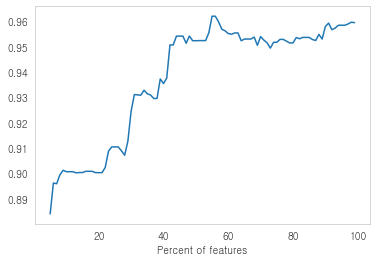

In [55]:
model = XGBClassifier(random_state= 1000)

cv_scores = []
for p in tqdm(range(5,100,1)):
    X_new = SelectPercentile(percentile=p).fit_transform(data , target)    
    cv_score = cross_val_score(model, X_new, target, scoring='roc_auc', cv=5).mean()
    cv_scores.append((p,cv_score))

# Print the best percentile
best_score = cv_scores[np.argmax([score for _, score in cv_scores])]
print(best_score)

# Plot the performance change with p
plt.plot([k for k, _ in cv_scores], [score for _, score in cv_scores])
plt.xlabel('Percent of features')
plt.grid() 

In [56]:
fs = SelectPercentile(percentile=best_score[0]).fit(data, target)
data = fs.transform(data)
test = fs.transform(test)

print(data.shape)

(23009, 53)


In [57]:
data = pd.DataFrame(data)
test = pd.DataFrame(test)

- ADASYN

In [58]:
ada = ADASYN(sampling_strategy=0.2, random_state=1000)
X_res, y_res = ada.fit_resample(data, target)

In [59]:
target.value_counts()

0    20811
1     2198
Name: 매칭성공여부, dtype: int64

In [60]:
y_res.value_counts()

0    20811
1     3948
Name: 매칭성공여부, dtype: int64

- Model 성능 확인

In [61]:
X_train, X_dev, y_train, y_dev = train_test_split(X_res, y_res ,stratify = y_res ,  test_size=0.3,   random_state=1000)

In [62]:
models = [ ExtraTreesClassifier(random_state = 1 ), 
         XGBClassifier(random_state = 1 ) 
         ]


for m in tqdm(models) :
    model = m.fit( X_train , y_train   )
    val_preds = model.predict_proba(X_dev)

    preds = model.predict_proba(test)
    print(m , '검증셋 성능 : ' ,roc_auc_score(y_dev, pd.DataFrame(val_preds)[1]) , '비율' , pd.DataFrame(preds)[1].mean() ) 

 50%|██████████████████████████████████████████                                          | 1/2 [00:02<00:02,  2.40s/it]

ExtraTreesClassifier(random_state=1) 검증셋 성능 :  0.9843528165417177 비율 0.1219584511467164


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.74s/it]

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None) 검증셋 성능 :  0.9771241202365081 비율 0.10739010572433472


- 최종 모델

In [63]:
ext = ExtraTreesClassifier(random_state = 0 )
ext = ext.fit(X_res , y_res )

In [64]:
preds = ext.predict_proba(test)

In [65]:
sub['pred'] = pd.DataFrame(preds)[1]

In [66]:
sub.to_csv('./submission/submission_1.csv' , index = False )